In [1]:
import umap 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import dgl
import torch
import plotly.express as px
import matplotlib.ticker as plticker

# set seeds
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

cos = torch.nn.CosineSimilarity(dim=0, eps=1e-08)

/n/sw/Mambaforge-22.11.1-4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read in trained embeddings
h_graph = pickle.load(open("/n/holylabs/LABS/mzitnik_lab/Users/ruthjohnson/transfer/full_h_embed_hms.pkl", 'rb'))

# meta data files
node_map_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper/construct_kg/phekg/new_node_map_df.csv")
node_map_df = node_map_df.sort_values(by='global_graph_index')

defn_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper/construct_kg/phekg/phecode_definitions1.2.csv")
part_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper/umap/Part.csv")

system_part_list = part_df.loc[part_df['PartTypeName'] == 'COMPONENT']['PartNumber'].values
system_part_inds = node_map_df.loc[node_map_df['node_id'].isin(system_part_list)]['global_graph_index'].values.tolist()

# Global UMAP

## Run umap and add metadata

In [ ]:
# list of phecode indices
keep_cat_list = ['infectious diseases', 'neoplasms', 'endocrine/metabolic',
       'hematopoietic', 'mental disorders', 'neurological',
       'sense organs',  'digestive',
       'genitourinary', 'dermatologic', 'respiratory', 'circulatory system',
       'musculoskeletal']

phecode_df = node_map_df.loc[node_map_df['ntype'] == 'PHECODE']
phecode_df = phecode_df.assign(node_id=phecode_df['node_id'].astype(float))
phecode_df = phecode_df.merge(defn_df[['category', 'phecode']], left_on='node_id', right_on='phecode', how='left')
phecode_df = phecode_df.assign(node_id=phecode_df['node_id'].astype(str))

phecode_inds = phecode_df.loc[phecode_df['category'].isin(keep_cat_list)]['global_graph_index'].values.tolist()

# list of ATC indices
atc_df = node_map_df.loc[node_map_df['ntype'] == 'ATC4']
atc_df = atc_df.assign(category=atc_df['node_id'].str.slice(0,1))
keep_atc_list = ['A', 'B', 'C', 'D', 'G', 'H', 'M', 'N', 'R', 'S']
atc_inds = atc_df.loc[atc_df['category'].isin(keep_atc_list)]['global_graph_index'].values.tolist()

# CPT codes
cpt_df = node_map_df.loc[node_map_df['ntype'] == 'CPT']
cpt_df = cpt_df[pd.to_numeric(cpt_df['node_id'], errors='coerce').notnull()]
cpt_df = cpt_df.assign(node_id=cpt_df['node_id'].astype(int))

cpt_df = cpt_df.assign(node_id=cpt_df['node_id'].astype(str))
cpt_inds = cpt_df['global_graph_index'].values.tolist()
cpt_df['category'] = cpt_df['node_id'].str.slice(0,1)

# ICD codes
icd_df = node_map_df.loc[node_map_df['ntype'] == 'ICD9CM']
icd_inds = icd_df['global_graph_index'].values.tolist()
icd_df['category'] = "ICD9CM"

/tmp/ipykernel_118629/1742622169.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icd_df['category'] = "ICD9CM"


In [4]:
#
# Run UMAP

# get embeddings
embed_mat = h_graph[[cpt_inds + system_part_inds + phecode_inds + atc_inds]].numpy()
embed_mat = umap.UMAP(n_components=2, metric='cosine', n_neighbors=50, min_dist=0.4).fit_transform(embed_mat)

In [5]:
# add metadata and labels
embed_df = pd.DataFrame(embed_mat)
diag_df = node_map_df.loc[node_map_df['global_graph_index'].isin(cpt_inds + system_part_inds + phecode_inds + atc_inds)]
embed_df['node_name'] = diag_df['node_name'].values
embed_df['node_id'] = diag_df['node_id'].values
embed_df['ntype'] = diag_df['ntype'].values

phecode_embed_df = embed_df.loc[embed_df['ntype']=='PHECODE'].merge(phecode_df[['node_id', 'category']], on='node_id', how='left')
atc_embed_df = embed_df.loc[embed_df['ntype'].isin(['ATC4'])].copy()
atc_embed_df['category'] = atc_embed_df['node_id'].str.slice(0,1)

cpt_embed_df = embed_df.loc[embed_df['ntype']=='CPT'].merge(cpt_df[['node_id', 'category']], on='node_id', how='left')
cpt_embed_df['category'] = "CPT"

lnc_embed_df = embed_df.merge(node_map_df.loc[node_map_df['ntype'] == 'LNC'][['node_id']], on='node_id', how='inner')
lnc_embed_df['category'] = "LNC"

icd_embed_df = embed_df.loc[embed_df['ntype'] == 'ICD9CM']
icd_embed_df['category'] = 'ICD9CM'

embed_df = pd.concat([cpt_embed_df, lnc_embed_df, phecode_embed_df, atc_embed_df])
embed_df.loc[embed_df['category'].isin(['mental disorders']), 'category'] = 'neurological'

embed_df = embed_df.merge(node_map_df, on=['node_name', 'node_id', 'ntype'], how='left')

In [8]:
fig_2d = px.scatter(
    embed_df.loc[embed_df['ntype'] == 'PHECODE'], x=0, y=1, color='category',
hover_data=["node_name", "node_id"], hover_name="node_name"
)
# hover name
fig_2d.update_layout(
    width=800,
    height=600,
)
fig_2d.update_traces(opacity=.9)
fig_2d.show()

## Phecodes 

In [9]:
c_digest = "#264653"
c_musko = "#2a9d8f"
c_derm = "#6a4c93"
c_resp = "#e9c46a"
c_neuro='#f4a261'
c_endo="#e76f51"
c_circ="#1565c0"
c_urinary='#e40066'
c_hemo="#6e4555"
c_sense='#7ABA78'
c_infec='brown'
c_default="#E2DAD6"
c_mental = "#8f2d56"
c_preg = "#3FA7D6"
c_neo = "#f6ae2d"
c_infect = "#3c6e71"

(-6.0, 12.0, -3.0, 13.5)

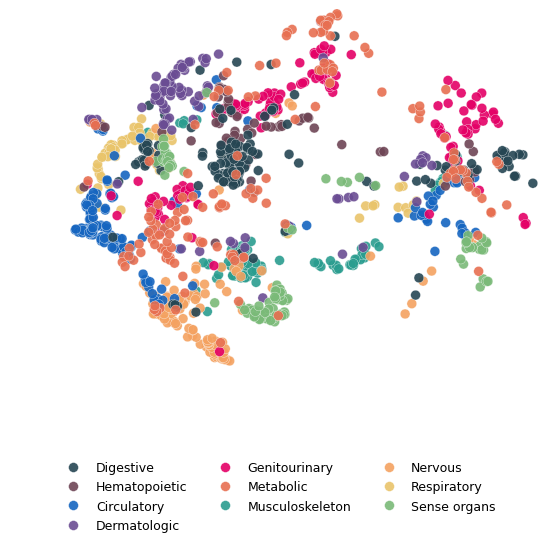

In [ ]:
#
# A) organ system phecodes
#

fig, ax = plt.subplots(figsize=(6.25, 6.0))

# musko (1)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'musculoskeletal')], x=0, y=1, hue='category', 
    palette=[c_musko], alpha=0.9, s=50, linewidth=0.25, edgecolor='white', ax=ax)
# resp (2)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'respiratory')], x=0, y=1, hue='category', 
    palette=[c_resp], alpha=0.9, s=50, linewidth=0.25, edgecolor='white', ax=ax)
# neuro (3)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'neurological')], x=0, y=1, hue='category', 
    palette=[c_neuro], alpha=0.9, s=50, linewidth=0.25, edgecolor='white', ax=ax)

sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'circulatory system')], x=0, y=1, hue='category', 
    palette=[c_circ], alpha=0.9, s=50, linewidth=0.25, edgecolor='white', ax=ax)
# urinary (5)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'genitourinary')], x=0, y=1, hue='category', 
    palette=[c_urinary], alpha=0.9, s=50, linewidth=0.25, edgecolor='white', ax=ax)
# hem (6)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'hematopoietic')], x=0, y=1, hue='category', 
    palette=[c_hemo], alpha=0.9, s=50, linewidth=0.25, edgecolor='white', ax=ax)

sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'digestive')], x=0, y=1, hue='category', 
    palette=[c_digest], alpha=0.9, s=50, linewidth=0.25, edgecolor='white', ax=ax)
# derm (8)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'dermatologic')], x=0, y=1, hue='category', 
    palette=[c_derm], alpha=0.9, s=50, linewidth=0.25, edgecolor='white', ax=ax)

# sense organs (9)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'sense organs')], x=0, y=1, hue='category', 
    palette=[c_sense], alpha=0.9, s=50,  linewidth=0.25, edgecolor='white', ax=ax)

# endo (10)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'] == 'endocrine/metabolic')], x=0, y=1, hue='category', 
    palette=[c_endo], alpha=0.9, s=50, linewidth=0.25, edgecolor='white', ax=ax)

# legend
handles, labels = ax.get_legend_handles_labels()
legend_order = [x-1 for x in [7, 6, 4, 8, 5, 10, 1, 3, 2, 9]]
new_handles = [handles[idx] for idx in legend_order]

new_labels = ['Digestive', 'Hematopoietic', 'Circulatory',
             'Dermatologic', 'Genitourinary', 'Metabolic', 'Musculoskeleton', 'Nervous', 'Respiratory',
             'Sense organs']
ax.legend(new_handles, new_labels)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, -0.45), ncol=3, title=None, frameon=False,
    fontsize=9
)

plt.ylim(-3, 13.5)
plt.xlim(-6, 12)

sns.despine(offset=2, trim=True, left=True, bottom=True)

plt.tight_layout()
plt.axis('off')

In [18]:
fig.savefig("umap_phecode.svg", dpi=300)

## ATC codes

(-6.0, 12.0, -3.0, 13.5)

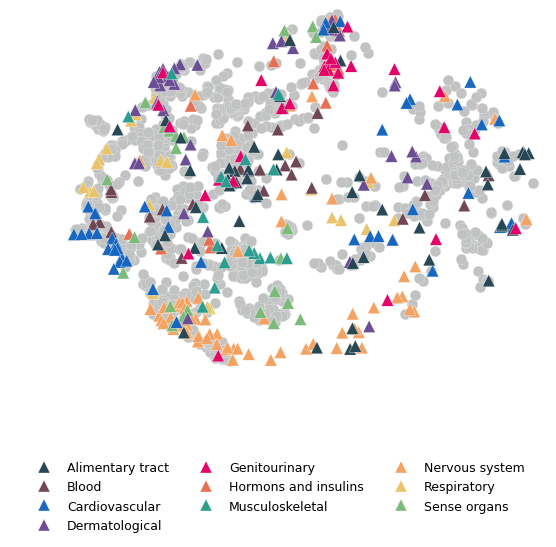

In [ ]:
#
# B) ATC
#
fig, ax = plt.subplots(figsize=(6.25, 6.0))

# phecode background
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE') & (embed_df['category'].isin(['endocrine/metabolic',
       'hematopoietic', 'mental disorders', 'neurological',
       'sense organs',  'digestive',
       'genitourinary', 'dermatologic', 'respiratory', 'circulatory system',
       'musculoskeletal']))], x=0, y=1,
    color="#C1C2C2", alpha=1.0, linewidth=0.15, s=60, ax=ax, edgecolor='white')

#######

# resp (0)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'] == 'R')], x=0, y=1, hue='category', 
    palette=[c_resp], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)
# neuro (1)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'] == 'N')], x=0, y=1, hue='category', 
    palette=[c_neuro], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)
# endo (2)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'].isin(['H']))], x=0, y=1, hue='category', 
    palette=[c_endo], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)
# hemo (3)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'].isin(['B']))], x=0, y=1, hue='category', 
    palette=[c_hemo], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)
# sense (4)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'].isin(['S']))], x=0, y=1, hue='category', 
    palette=[c_sense], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)
# derm (5)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'] == 'D')], x=0, y=1, hue='category', 
    palette=[c_derm], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)
# circ (6)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'].isin(['C']))], x=0, y=1, hue='category', 
    palette=[c_circ], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)
# digestive (7)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'] == 'A')], x=0, y=1, hue='category', 
    palette=[c_digest], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)
# urinary (8)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'].isin(['G']))], x=0, y=1, hue='category', 
    palette=[c_urinary], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)
# musko (9)
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'ATC4') & (embed_df['category'] == 'M')], x=0, y=1, hue='category', 
    palette=[c_musko], marker='^', alpha=0.99, s=80, linewidth=0.25, edgecolor='white', ax=ax)

handles, labels = ax.get_legend_handles_labels()
legend_order = [x+0 for x in [7, 3, 6, 5, 8, 2, 9, 1, 0, 4]]
new_handles = [handles[idx] for idx in legend_order]

new_labels = ["Alimentary tract", "Blood", 'Cardiovascular', "Dermatological",
           "Genitourinary", "Hormons and insulins", "Musculoskeletal", 
           "Nervous system", "Respiratory", 
            "Sense organs"]
ax.legend(new_handles, new_labels)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, -0.45), ncol=3, title=None, frameon=False,
    fontsize=9
)

plt.ylim(-3, 13.5)
plt.xlim(-6, 12)

sns.despine(offset=2, trim=True, left=True, bottom=True)

plt.tight_layout()
plt.axis('off')

In [16]:
fig.savefig("umap_atc.svg", dpi=300)

## CPT and LNC codes

### Lupus

In [7]:
# Lupus
node_map_df.query("node_id == '695.42'")

ntype                     node_name node_id  global_graph_index
931  PHECODE  Systemic lupus erythematosus  695.42               25595

In [ ]:
cos_list = []
disease_ind = 25595
for i, row in embed_df.iterrows():
    cpt_ind = row['global_graph_index']
    d = cos(h_graph[disease_ind], h_graph[cpt_ind])
    cos_list.append(d.item())
embed_df['cos'] = cos_list

In [124]:
highlight_inds = [632, 24028, 507, 22075, 506, 23254, 23255, 
                  21433, 86141, 16786,
                  22075, 18404, 356, 193, 870,
                   85004 , 22785, 16588, 23284]
# antinuclear ab, urine, sed rate(cpt), sed rate(lnc), sed (cpt)
#   phospholipid, phospholipid, ribonuclear, comp factor H, comp C4, comp 3
#   C-protein, C-protein (cpt), Erythrocyte, Erythrocyte width, Eryth mcv,
# Prothrombin, PROTHROMBIN TIME, biopsy of kidney, muscle biopsy

(-5.0, 14.0, -5.0, 15.0)

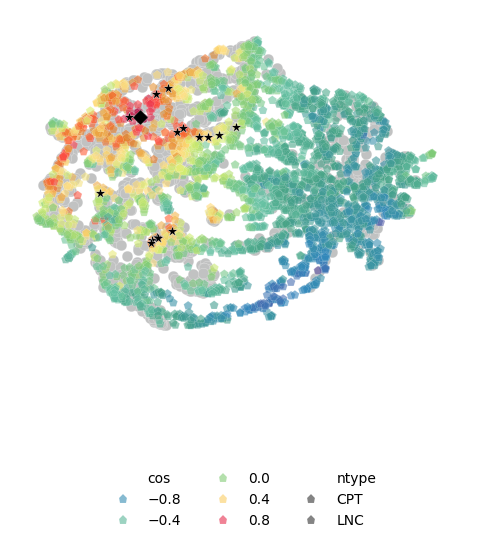

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4.75))

# phecode background
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE')], x=0, y=1,
    color="#C1C2C2", alpha=1.0, linewidth=0.15, s=60, ax=ax, edgecolor='white')

import matplotlib.colors

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#5e4fa2"], # purple
          [norm(-0.9), "#3288bd"], # blue 
          [norm(-0.6), "#47a386"], # deeper green
          [norm(-0.3), "#66c2a5"], # green
            [norm(0.0), "#80cb75"], # light green
          [norm(0.2), "#dbf070"], # yellow (muted)
          [norm( 0.3), "#fee08b"], # yellow 
          [norm( 0.4), "#ffd86a"], # brighter yellow
          [norm(0.55), "#df8329"], # lighter orange
          [norm( 0.65), "#ff6232"], # bright orange
          [norm(0.8), "#fa3c51"], # coral red
          [norm(1.0), "#9e0142"]] # dark red

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
#cmap="Spectral_r"

# phecodes
sns.scatterplot(embed_df.loc[embed_df['ntype'].isin(['CPT', 'LNC'])], x=0, y=1, s=45, ax=ax, 
                hue='cos', palette=cmap, linewidth=0.15, style='ntype',
                edgecolor='white', markers=['p', 'p'], alpha=0.6)

# add disease point
sns.scatterplot(embed_df.loc[(embed_df['global_graph_index'] == disease_ind)], x=0, y=1,
    color="black", alpha=1.0, linewidth=0.15, s=60, ax=ax, edgecolor='white', marker='D')

# highlight inds
sns.scatterplot(embed_df.loc[(embed_df['global_graph_index'].isin(highlight_inds))], x=0, y=1,
    color="black", alpha=1.0, linewidth=0.25, s=60, ax=ax, edgecolor='white', marker='*')


sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, -0.45), ncol=3, title=None, frameon=False
)

plt.ylim(-5, 15)
plt.xlim(-5, 14)

sns.despine(offset=2, trim=True, left=True, bottom=True)

plt.axis('off')

In [35]:
fig_2d = px.scatter(
    embed_df.loc[embed_df['ntype'].isin(['CPT', 'LNC'])], x=0, y=1, color='cos',
hover_data=["node_name", "node_id"], hover_name="node_name"
)
# hover name
fig_2d.update_layout(
    width=500,
    height=500,
)
fig_2d.update_traces(opacity=.9)
fig_2d.show()

In [127]:
fig.savefig("umap_lupus.svg", dpi=300)

### Grave's disease

In [8]:
# Graves
node_map_df.query("node_id == '242.1'")

ntype                node_name node_id  global_graph_index
4705   ICD9CM  Toxic uninodular goiter   242.1                3463
159   PHECODE          Graves' disease   242.1               24436

In [6]:
cos_list = []
disease_ind = 24436
for i, row in embed_df.iterrows():
    cpt_ind = row['global_graph_index']
    d = cos(h_graph[disease_ind], h_graph[cpt_ind])
    cos_list.append(d.item())
embed_df['cos'] = cos_list

In [ ]:
highlight_inds = [159, 160, 208, 936, 157, 23847, 23848, 67, 22651, 
                  21862, 22122, 22378, 67089]

node_map_df.loc[node_map_df['global_graph_index'].isin(highlight_inds)]

(-5.0, 14.0, -5.0, 15.0)

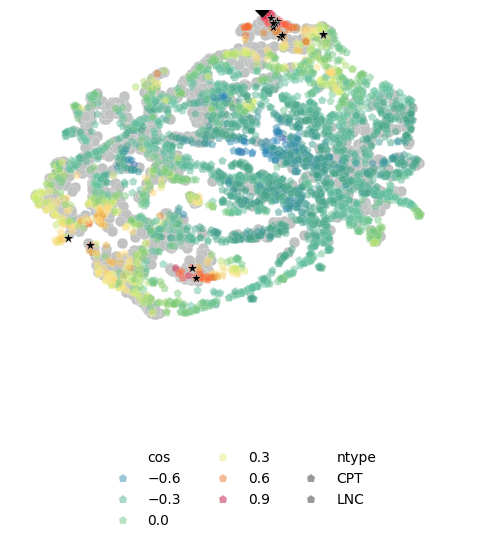

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4.75))

# phecode background
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE')], x=0, y=1,
    color="#C1C2C2", alpha=1.0, linewidth=0.15, s=60, ax=ax, edgecolor='white')

import matplotlib.colors

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#5e4fa2"], # purple
          [norm(-0.9), "#3288bd"], # blue 
          [norm(-0.6), "#47a386"], # deeper green
          [norm(-0.3), "#66c2a5"], # green
            [norm(0.0), "#80cb75"], # light green
          [norm(0.2), "#dbf070"], # yellow (muted)
          [norm( 0.3), "#fee08b"], # yellow 
          [norm( 0.4), "#ffd86a"], # brighter yellow
          [norm(0.55), "#df8329"], # lighter orange
          [norm( 0.65), "#ff6232"], # bright orange
          [norm(0.8), "#fa3c51"], # coral red
          [norm(1.0), "#9e0142"]] # dark red

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
#cmap="Spectral_r"

# phecodes
sns.scatterplot(embed_df.loc[embed_df['ntype'].isin(['CPT', 'LNC'])], x=0, y=1, s=40, ax=ax, 
                hue='cos', palette=cmap, linewidth=0.15, style='ntype',
                edgecolor='white', markers=['p', 'p'], alpha=0.5)

# add disease point
sns.scatterplot(embed_df.loc[(embed_df['global_graph_index'] == disease_ind)], x=0, y=1,
    color="black", alpha=1.0, linewidth=0.15, s=60, ax=ax, edgecolor='white', marker='D')

# highlight inds
sns.scatterplot(embed_df.loc[(embed_df['global_graph_index'].isin(highlight_inds))], x=0, y=1,
    color="black", alpha=1.0, linewidth=0.25, s=60, ax=ax, edgecolor='white', marker='*')

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, -0.45), ncol=3, title=None, frameon=False
)

plt.ylim(-5, 15)
plt.xlim(-5, 14)

sns.despine(offset=2, trim=True, left=True, bottom=True)

plt.axis('off')

In [13]:
fig_2d = px.scatter(
    embed_df.loc[embed_df['ntype'].isin(['CPT', 'LNC'])], x=0, y=1, color='cos',
hover_data=["node_name", "node_id"], hover_name="node_name"
)
# hover name
fig_2d.update_layout(
    width=500,
    height=500,
)
fig_2d.update_traces(opacity=.9)
fig_2d.show()

In [15]:
fig.savefig("umap_graves.svg", dpi=300)

### MS

In [65]:
# Graves
node_map_df.query("node_id == '335.0'")

ntype                 node_name node_id  global_graph_index
7140   ICD9CM  Werdnig-Hoffmann disease   335.0                5898
2176  PHECODE        Multiple sclerosis   335.0               24762

In [66]:
cos_list = []
disease_ind = 24762
for i, row in embed_df.iterrows():
    cpt_ind = row['global_graph_index']
    d = cos(h_graph[disease_ind], h_graph[cpt_ind])
    cos_list.append(d.item())
embed_df['cos'] = cos_list

(-5.0, 14.0, -5.0, 15.0)

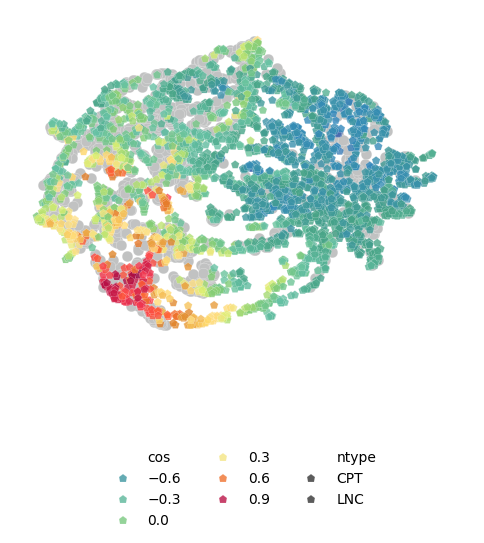

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4.75))

# phecode background
sns.scatterplot(embed_df.loc[(embed_df['ntype'] == 'PHECODE')], x=0, y=1,
    color="#C1C2C2", alpha=1.0, linewidth=0.15, s=60, ax=ax, edgecolor='white')

import matplotlib.colors

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#5e4fa2"], # purple
          [norm(-0.9), "#3288bd"], # blue 
          [norm(-0.6), "#47a386"], # deeper green
          [norm(-0.3), "#66c2a5"], # green
            [norm(0.0), "#80cb75"], # light green
          [norm(0.2), "#dbf070"], # yellow (muted)
          [norm( 0.3), "#fee08b"], # yellow 
          [norm( 0.4), "#ffd86a"], # brighter yellow
          [norm(0.55), "#df8329"], # lighter orange
          [norm( 0.65), "#ff6232"], # bright orange
          [norm(0.8), "#fa3c51"], # coral red
          [norm(1.0), "#9e0142"]] # dark red

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
#cmap="Spectral_r"

# phecodes
sns.scatterplot(embed_df.loc[embed_df['ntype'].isin(['CPT', 'LNC'])], x=0, y=1, s=40, ax=ax, 
                hue='cos', palette=cmap, linewidth=0.15, style='ntype',
                edgecolor='white', markers=['p', 'p'], alpha=0.8)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, -0.45), ncol=3, title=None, frameon=False
)

plt.ylim(-5, 15)
plt.xlim(-5, 14)


sns.despine(offset=2, trim=True, left=True, bottom=True)


plt.axis('off')


In [68]:
fig_2d = px.scatter(
    embed_df.loc[embed_df['ntype'].isin(['CPT', 'LNC'])], x=0, y=1, color='cos',
hover_data=["node_name", "node_id"], hover_name="node_name"
)
# hover name
fig_2d.update_layout(
    width=500,
    height=500,
)
fig_2d.update_traces(opacity=.9)
fig_2d.show()

In [20]:
fig.savefig("umap_ms.svg", dpi=300)

# Local UMAP

### Digestive

In [194]:
icd_map_df = pd.read_csv("../construct_kg/phekg/phecode_icd9_map_unrolled.csv")
icd_map_df = icd_map_df.assign(icd9=icd_map_df['icd9'].str.lstrip('0').values)

phecode_df = node_map_df.loc[node_map_df['ntype'] == 'PHECODE']
phecode_df = phecode_df.assign(node_id=phecode_df['node_id'].astype(float))
phecode_df = phecode_df.merge(defn_df[['category', 'phecode']], left_on='node_id', right_on='phecode', how='left')
phecode_df = phecode_df.assign(node_id=phecode_df['node_id'].astype(str))

joint_map_df = icd_map_df.merge(
    defn_df[['phenotype', 'category', 'phecode']], on='phecode', how='left')
joint_map_df = joint_map_df.loc[joint_map_df['category'].isin(['digestive'])]

In [195]:
digestive_df = node_map_df.loc[(node_map_df['ntype'] == 'ICD9CM') 
                & (node_map_df['node_id'].isin(joint_map_df['icd9'].values))]

digestive_df = digestive_df.merge(joint_map_df[['category','icd9', 'phecode']], left_on='node_id', 
                                  right_on='icd9', how='inner')[['phecode', 'category', 'global_graph_index', 'ntype']].drop_duplicates()

#digestive_df = pd.concat(
#    [phecode_df.loc[phecode_df['category'].isin(['digestive'])],
#      digestive_df]
#    )
digestive_df = phecode_df.loc[phecode_df['category'].isin(['digestive'])]

digestive_df = node_map_df.loc[node_map_df['global_graph_index'].isin(digestive_df['global_graph_index'].values)]

digestive_inds = digestive_df['global_graph_index'].values.tolist()

In [201]:
all_inds = list(set(digestive_inds))
#
# digest_atc_inds

local_embed_mat = h_graph[all_inds].numpy()

local_embed_mat = umap.UMAP(n_components=2, metric='cosine', n_neighbors=10, min_dist=0.5).fit_transform(local_embed_mat)

In [202]:
# add metadata and labels
local_embed_df = pd.DataFrame(local_embed_mat)
diag_df = node_map_df.loc[node_map_df['global_graph_index'].isin(all_inds)]
local_embed_df['node_name'] = diag_df['node_name'].values
local_embed_df['node_id'] = diag_df['node_id'].values
local_embed_df['ntype'] = diag_df['ntype'].values
local_embed_df['global_graph_index'] = diag_df['global_graph_index'].values
local_embed_df['category'] = local_embed_df['node_id'].str.slice(0,2)

joint_map_df = joint_map_df.assign(ntype=['ICD9CM']*len(joint_map_df))
joint_map_df['node_id'] = joint_map_df['icd9'].values 

local_embed_df = local_embed_df.merge(joint_map_df[['phecode', 'ntype', 'node_id', 'icd9']], on=['ntype', 'node_id'], how='left').drop_duplicates()
local_embed_df.loc[local_embed_df['ntype'] == 'ICD9CM', 'category'] = local_embed_df.loc[local_embed_df['ntype'] == 'ICD9CM']['phecode'].astype(str).str.slice(0,2)
local_embed_df.loc[local_embed_df['ntype'] == 'PHECODE', 'phecode'] = local_embed_df.loc[local_embed_df['ntype'] == 'PHECODE']['node_id'].astype(float)
local_embed_df['phecode'] = local_embed_df['phecode'].astype(float)

In [ ]:
local_embed_df.loc[local_embed_df['phecode'].between(520.0, 526.99), 'category'] = 'teeth' #"Disorders of teeth and jaws"
local_embed_df.loc[local_embed_df['phecode'].between(527.0, 529.99), 'category'] = 'mouth' # "Disorders of mouth"
local_embed_df.loc[local_embed_df['phecode'].between(530.0, 530.99), 'category'] = "Esophageal"
local_embed_df.loc[local_embed_df['phecode'].between(532.0, 532.99), 'category'] = "Esophageal"
local_embed_df.loc[local_embed_df['phecode'].between(531.0, 531.99), 'category'] = "Gastro ulcer"

local_embed_df.loc[local_embed_df['phecode'].between(535.0, 537.99), 'category'] = "stomach"
local_embed_df.loc[local_embed_df['phecode'].between(539.0, 539.99), 'category'] = "Bariatric"
local_embed_df.loc[local_embed_df['phecode'].between(540.0, 540.99), 'category'] = "Appendiceal"

local_embed_df.loc[local_embed_df['phecode'].between(578.0, 579.99), 'category'] = "Other"
local_embed_df.loc[local_embed_df['phecode'].between(565.0, 569.99), 'category'] = "Other"
local_embed_df.loc[local_embed_df['phecode'].between(555.0, 564.99), 'category'] = "Noninfective"
local_embed_df.loc[local_embed_df['phecode'].between(550.0, 550.99), 'category'] = "hernia"
local_embed_df.loc[local_embed_df['phecode'].between(570.0, 573.99), 'category'] = "Liver"
local_embed_df.loc[local_embed_df['phecode'].between(574, 576.99), 'category'] = "Biliary"
local_embed_df.loc[local_embed_df['phecode'].between(578.0, 579.99), 'category'] = "Other"
local_embed_df.loc[local_embed_df['phecode'].between(577, 577.99), 'category'] = "Pancreatic"

count_df = local_embed_df.groupby('category').count().reset_index()
keep_cat = count_df.loc[count_df[0] >= 5]['category'].values

In [219]:
fig_2d = px.scatter(
        local_embed_df, x=0, y=1, color="category",
    hover_name="node_name", hover_data=['node_name', 'node_id']
    )

# hover name
fig_2d.update_layout(
    width=700,
    height=600,
)
fig_2d.update_traces(opacity=.7)
fig_2d.show()

Text(0.5, 1.0, 'Teeth and mouth disorders')

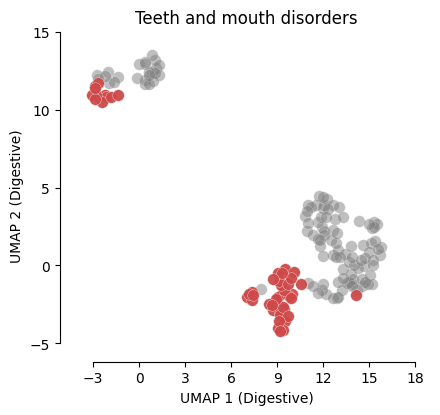

In [ ]:
fig, ax = plt.subplots(figsize=(4.75, 4.25))

sns.scatterplot(local_embed_df, 
                x=0, y=1, alpha=0.5, s=70, linewidth=0.25, edgecolor='white', ax=ax,
                color='gray'
)

sns.scatterplot(local_embed_df.loc[local_embed_df['category'].isin(['teeth', 'mouth'])], 
                x=0, y=1, alpha=0.9, s=70, linewidth=0.25, edgecolor='white', ax=ax,
                color='#D04848'
)

plt.xlabel("UMAP 1 (Digestive)")
plt.ylabel("UMAP 2 (Digestive)")

plt.xlim(-5, 19)
plt.ylim(-6, 15)

loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

sns.despine(offset=2, trim=True)

plt.title("Teeth and mouth disorders")

In [269]:
fig.savefig("local_teeth.svg", dpi=300)

Text(0.5, 1.0, 'Biliary system')

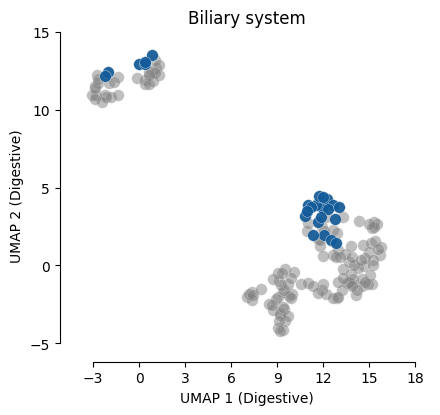

In [ ]:
fig, ax = plt.subplots(figsize=(4.75, 4.25))

sns.scatterplot(local_embed_df, 
                x=0, y=1, alpha=0.5, s=70, linewidth=0.25, edgecolor='white', ax=ax,
                color='gray'
)

sns.scatterplot(local_embed_df.loc[local_embed_df['category'].isin(['Liver', 'Biliary'])], 
                x=0, y=1, alpha=0.9, s=70, linewidth=0.25, edgecolor='white', ax=ax,
                color='#125B9A'
)

plt.xlabel("UMAP 1 (Digestive)")
plt.ylabel("UMAP 2 (Digestive)")

plt.xlim(-5, 19)
plt.ylim(-6, 15)

loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

sns.despine(offset=2, trim=True)

plt.title("Biliary system")

In [271]:
fig.savefig("local_biliary.svg", dpi=300)

Text(0.5, 1.0, 'Functional digestive disorders')

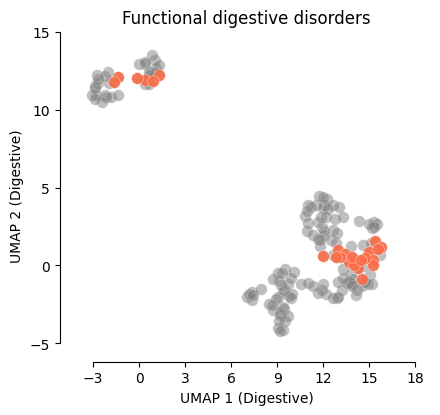

In [ ]:
fig, ax = plt.subplots(figsize=(4.75, 4.25))

sns.scatterplot(local_embed_df, 
                x=0, y=1, alpha=0.5, s=70, linewidth=0.25, edgecolor='white', ax=ax,
                color='gray'
)

sns.scatterplot(local_embed_df.loc[local_embed_df['category'].isin(['Noninfective'])], 
                x=0, y=1, alpha=0.9, s=70, linewidth=0.25, edgecolor='white', ax=ax,
                color='#FB6D48'
)

sns.despine(offset=0, trim=False)

plt.xlabel("UMAP 1 (Digestive)")
plt.ylabel("UMAP 2 (Digestive)")

plt.xlim(-5, 19)
plt.ylim(-6, 15)

loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

sns.despine(offset=2, trim=True)

plt.title("Functional digestive disorders")

In [273]:
fig.savefig("local_functional.svg", dpi=300)